이제 데이터셋에 맞게 불러온 모델을 변경하여 학습해봅시다

https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models

path = '/content/drive/MyDrive/Teaching/PD 2401/wildcats'

train_data = datasets.ImageFolder(path + '/train', transform = transforms.ToTensor())
valid_data = datasets.ImageFolder(path + '/valid', transform = transforms.ToTensor())
test_data = datasets.ImageFolder(path + '/test', transform = transforms.ToTensor())

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers = 2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle =True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers = 2)

https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.MobileNet_V3_Small_Weights

모바일넷을 불러오겟습니다



In [2]:
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
#model = models.mobilenet_v3_small(weights='DEFAULT')   # 이렇게 적어도 동일합니다.

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 40.9MB/s]


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

기존 레이어들을 그대로 두고 마지막 레이어를 현재 데이터셋에 맞게 10개의 분류를 할 수 있게 변경해야 합니다.

레이어에 접근은 모델 프린트를 보고 찾을 수 있습니다.


In [4]:
model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [5]:
model.classifier[-1]  # 마지막 레이어이므로 -1로 지정 가능능
#model.classifier[3]   # 직접 번호를 지정해도 됨됨

Linear(in_features=1024, out_features=1000, bias=True)

In [6]:
type(model.classifier)

torch.nn.modules.container.Sequential

In [7]:
model.features[0]  # 다른 레이어도 확인 가능함

Conv2dNormActivation(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (2): Hardswish()
)

In [8]:
model.features[0][2]

Hardswish()

Transfer Learning 에서는 기존 학습된 파라미터를 활용하는데, 여기에서는 모든 레이어를 학습하지 않게하고 마지막 레이어를 변경하겠습니다.

In [9]:
for param in model.parameters():
  param.requires_grad = False   # 모든 층의 파라미터를 학습하지 않도록 합니다.


In [10]:
for name, param in model.named_parameters():
  print(name, param.shape)

features.0.0.weight torch.Size([16, 3, 3, 3])
features.0.1.weight torch.Size([16])
features.0.1.bias torch.Size([16])
features.1.block.0.0.weight torch.Size([16, 1, 3, 3])
features.1.block.0.1.weight torch.Size([16])
features.1.block.0.1.bias torch.Size([16])
features.1.block.1.fc1.weight torch.Size([8, 16, 1, 1])
features.1.block.1.fc1.bias torch.Size([8])
features.1.block.1.fc2.weight torch.Size([16, 8, 1, 1])
features.1.block.1.fc2.bias torch.Size([16])
features.1.block.2.0.weight torch.Size([16, 16, 1, 1])
features.1.block.2.1.weight torch.Size([16])
features.1.block.2.1.bias torch.Size([16])
features.2.block.0.0.weight torch.Size([72, 16, 1, 1])
features.2.block.0.1.weight torch.Size([72])
features.2.block.0.1.bias torch.Size([72])
features.2.block.1.0.weight torch.Size([72, 1, 3, 3])
features.2.block.1.1.weight torch.Size([72])
features.2.block.1.1.bias torch.Size([72])
features.2.block.2.0.weight torch.Size([24, 72, 1, 1])
features.2.block.2.1.weight torch.Size([24])
features.2.

In [11]:
num_ftrs = model.classifier[-1].in_features  # 마지막 층의 입력 feature 개수를 추출합니다.
model.classifier[-1] = nn.Linear(num_ftrs, 10)  # 최종으로 분류할 클래스 개수로 새로 지정합니다.
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

모델의 파라미터가 학습되지 않게 변경되었는지 확인해봅시다

In [12]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

이제 학습을 해봅시다.

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [14]:
from tqdm import tqdm

size = len(train_loader.dataset)  # 데이터셋 길이 확인
model.train()   # 모델을 훈련모드로

epochs = 30
losses = []  # epoch마다 loss 변화 저장 변수
acces = []  # epoch마다 acc변화 저장 변수
losses_val = []  # epoch마다 loss 변화 저장 변수, valid_dataset
acces_val = []  # epoch마다 acc변화 저장 변수

for i in range(epochs):

  model.train() # 학습 모드
  train_loss, correct = 0, 0  # loss와 정확도 계산 목적
  for X, y in tqdm(train_loader): # tqdm으로 진행상황 확인 가능
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)  # 예측 계산
      loss = loss_fn(pred, y)  # loss 계산
      train_loss += loss.item()  # loss 누적
      correct += (pred.argmax(1) == y).sum()  # 맞춘 개수 확인

      # Backpropagation
      optimizer.zero_grad()  # gradient 초기화
      loss.backward()   # gradient 계산
      optimizer.step()   # w,b 반영

  # train 데이터셋에 대한 정확도 계산
  acc = correct/size
  losses.append(loss.item())
  acces.append(acc.item())
  print('epoch:',i+1)
  print(f"loss: {train_loss:>7f}  acc:{acc:>5f}")

  # 에포크 마다, validation 데이터셋 정확도 계산
  valid_loss = 0
  valid_correct = 0

  model.eval()  # 평가용 모드
  with torch.no_grad():
    for x_val, y_val in valid_loader:  # vaildation set에서 정확도 평가
      x_val, y_val = x_val.to(device), y_val.to(device)
      pred_val = model(x_val)
      valid_loss += loss_fn(pred_val, y_val).item()
      print(pred_val.shape, pred_val.argmax(1))
      valid_correct += (pred_val.argmax(1) == y_val).sum().item()

      break # 1개의 배치만 테스트(시간 때문에)

    valid_acc = valid_correct/(batch_size)
    losses_val.append(valid_loss)
    acces_val.append(valid_acc)
    print(f"val_loss: {valid_loss:>7f}  val_acc:{valid_acc:>5f}")



  0%|          | 0/74 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 74/74 [05:10<00:00,  4.19s/it]

epoch: 1
loss: 92.774363  acc:0.687901


torch.Size([32, 10]) tensor([1, 0, 7, 1, 9, 0, 0, 7, 4, 8, 8, 0, 8, 0, 9, 0, 9, 2, 3, 9, 1, 1, 4, 3,
        2, 5, 0, 0, 6, 4, 4, 7], device='cuda:0')
val_loss: 0.632221  val_acc:0.718750


100%|██████████| 74/74 [00:09<00:00,  7.77it/s]

epoch: 2
loss: 44.709638  acc:0.849508


torch.Size([32, 10]) tensor([7, 5, 7, 7, 3, 9, 9, 2, 1, 1, 3, 7, 6, 0, 7, 3, 0, 4, 0, 8, 8, 0, 0, 0,
        8, 9, 7, 5, 1, 0, 1, 0], device='cuda:0')
val_loss: 0.511279  val_acc:0.781250


100%|██████████| 74/74 [00:09<00:00,  8.17it/s]

epoch: 3
loss: 34.026607  acc:0.883283


torch.Size([32, 10]) tensor([3, 9, 0, 4, 4, 5, 3, 6, 7, 3, 3, 2, 1, 4, 0, 4, 8, 7, 8, 1, 7, 0, 5, 0,
        7, 2, 6, 0, 1, 5, 3, 9], device='cuda:0')
val_loss: 0.566516  val_acc:0.812500


100%|██████████| 74/74 [00:08<00:00,  8.37it/s]

epoch: 4
loss: 28.702503  acc:0.902950


torch.Size([32, 10]) tensor([6, 1, 3, 5, 7, 6, 0, 9, 4, 1, 8, 1, 6, 8, 4, 4, 7, 7, 9, 3, 1, 5, 6, 0,
        0, 7, 7, 6, 8, 9, 7, 9], device='cuda:0')
val_loss: 0.479174  val_acc:0.812500


100%|██████████| 74/74 [00:09<00:00,  7.78it/s]

epoch: 5
loss: 25.563545  acc:0.912783


torch.Size([32, 10]) tensor([6, 8, 5, 0, 9, 0, 0, 3, 7, 4, 0, 4, 1, 0, 1, 7, 3, 8, 4, 0, 6, 8, 1, 7,
        5, 6, 0, 9, 6, 6, 0, 0], device='cuda:0')
val_loss: 0.468686  val_acc:0.812500


100%|██████████| 74/74 [00:09<00:00,  7.76it/s]

epoch: 6
loss: 22.704487  acc:0.923899


torch.Size([32, 10]) tensor([7, 0, 9, 0, 3, 4, 9, 3, 2, 5, 6, 1, 7, 8, 2, 5, 6, 1, 0, 9, 1, 6, 7, 4,
        6, 7, 8, 7, 0, 0, 8, 3], device='cuda:0')
val_loss: 0.416350  val_acc:0.843750


100%|██████████| 74/74 [00:09<00:00,  7.41it/s]

epoch: 7
loss: 21.180318  acc:0.917914


torch.Size([32, 10]) tensor([3, 6, 6, 4, 0, 5, 4, 7, 8, 1, 1, 5, 1, 3, 0, 5, 4, 1, 9, 6, 9, 0, 7, 4,
        8, 8, 2, 3, 5, 8, 2, 0], device='cuda:0')
val_loss: 0.332187  val_acc:0.812500


100%|██████████| 74/74 [00:09<00:00,  8.17it/s]

epoch: 8
loss: 19.587591  acc:0.930740


torch.Size([32, 10]) tensor([7, 9, 7, 5, 7, 9, 4, 9, 4, 7, 5, 4, 8, 0, 4, 9, 2, 1, 4, 1, 0, 2, 5, 3,
        0, 0, 6, 9, 1, 8, 6, 8], device='cuda:0')
val_loss: 0.333218  val_acc:0.812500


100%|██████████| 74/74 [00:09<00:00,  7.75it/s]

epoch: 9
loss: 18.985467  acc:0.935443


torch.Size([32, 10]) tensor([7, 5, 9, 4, 6, 1, 0, 0, 5, 7, 6, 3, 1, 7, 5, 0, 2, 3, 1, 9, 2, 3, 0, 6,
        4, 8, 6, 7, 1, 4, 5, 0], device='cuda:0')
val_loss: 0.279989  val_acc:0.875000


100%|██████████| 74/74 [00:09<00:00,  8.04it/s]

epoch: 10
loss: 17.584362  acc:0.945703


torch.Size([32, 10]) tensor([5, 7, 0, 9, 7, 0, 2, 3, 4, 1, 7, 0, 7, 8, 8, 1, 0, 3, 0, 6, 0, 6, 4, 8,
        5, 1, 9, 1, 4, 9, 0, 3], device='cuda:0')
val_loss: 0.391051  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.61it/s]

epoch: 11
loss: 16.312052  acc:0.951689


torch.Size([32, 10]) tensor([0, 6, 4, 6, 3, 5, 9, 3, 7, 8, 9, 5, 1, 0, 0, 3, 0, 1, 0, 4, 4, 0, 6, 0,
        8, 1, 3, 1, 7, 2, 4, 2], device='cuda:0')
val_loss: 0.386390  val_acc:0.781250


100%|██████████| 74/74 [00:09<00:00,  7.67it/s]

epoch: 12
loss: 14.765953  acc:0.949551


torch.Size([32, 10]) tensor([2, 1, 7, 5, 4, 6, 8, 8, 4, 0, 9, 1, 2, 6, 0, 5, 5, 6, 6, 4, 0, 1, 9, 4,
        0, 8, 0, 0, 6, 0, 9, 3], device='cuda:0')
val_loss: 0.451254  val_acc:0.843750


100%|██████████| 74/74 [00:09<00:00,  7.72it/s]

epoch: 13
loss: 15.679636  acc:0.952971


torch.Size([32, 10]) tensor([5, 6, 3, 8, 0, 8, 9, 6, 4, 1, 1, 1, 8, 2, 1, 6, 5, 6, 0, 3, 9, 4, 8, 4,
        7, 2, 3, 2, 0, 7, 5, 7], device='cuda:0')
val_loss: 0.380197  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.89it/s]

epoch: 14
loss: 14.060287  acc:0.954254


torch.Size([32, 10]) tensor([0, 7, 5, 1, 6, 8, 7, 0, 3, 0, 8, 3, 4, 2, 8, 9, 1, 1, 0, 0, 5, 5, 2, 7,
        4, 6, 4, 7, 2, 7, 2, 3], device='cuda:0')
val_loss: 0.320810  val_acc:0.812500


100%|██████████| 74/74 [00:09<00:00,  7.90it/s]

epoch: 15
loss: 13.205753  acc:0.958957


torch.Size([32, 10]) tensor([1, 9, 5, 4, 9, 0, 5, 3, 0, 0, 8, 6, 7, 7, 4, 7, 2, 9, 8, 3, 4, 6, 6, 4,
        3, 4, 6, 1, 5, 7, 3, 8], device='cuda:0')
val_loss: 0.451969  val_acc:0.812500


100%|██████████| 74/74 [00:09<00:00,  7.62it/s]

epoch: 16
loss: 12.226902  acc:0.964087


torch.Size([32, 10]) tensor([4, 3, 5, 5, 7, 8, 7, 7, 9, 5, 0, 0, 8, 5, 1, 7, 9, 8, 1, 0, 2, 6, 4, 9,
        6, 7, 0, 0, 1, 2, 3, 7], device='cuda:0')
val_loss: 0.176655  val_acc:0.906250


100%|██████████| 74/74 [00:09<00:00,  7.47it/s]

epoch: 17
loss: 11.995894  acc:0.957247


torch.Size([32, 10]) tensor([9, 3, 1, 1, 9, 8, 6, 0, 5, 8, 6, 0, 7, 1, 7, 0, 9, 5, 6, 8, 7, 0, 7, 0,
        9, 3, 6, 1, 2, 0, 9, 2], device='cuda:0')
val_loss: 0.288171  val_acc:0.906250


100%|██████████| 74/74 [00:08<00:00,  8.37it/s]

epoch: 18
loss: 11.394103  acc:0.967080


torch.Size([32, 10]) tensor([0, 0, 0, 1, 7, 8, 2, 1, 8, 5, 4, 3, 4, 0, 9, 9, 6, 2, 5, 6, 0, 4, 5, 8,
        2, 0, 1, 7, 8, 1, 7, 0], device='cuda:0')
val_loss: 0.446259  val_acc:0.843750


100%|██████████| 74/74 [00:10<00:00,  7.37it/s]

epoch: 19
loss: 11.779287  acc:0.961522


torch.Size([32, 10]) tensor([3, 4, 1, 0, 0, 7, 0, 2, 6, 0, 0, 6, 0, 6, 3, 4, 1, 5, 8, 6, 5, 2, 1, 7,
        1, 4, 5, 8, 8, 3, 7, 1], device='cuda:0')
val_loss: 0.355813  val_acc:0.843750


100%|██████████| 74/74 [00:09<00:00,  7.41it/s]

epoch: 20
loss: 11.547216  acc:0.963232


torch.Size([32, 10]) tensor([3, 4, 1, 7, 2, 0, 9, 6, 8, 0, 8, 7, 0, 5, 0, 0, 0, 4, 6, 2, 0, 6, 3, 6,
        5, 5, 3, 4, 6, 7, 2, 3], device='cuda:0')
val_loss: 0.350695  val_acc:0.875000


100%|██████████| 74/74 [00:09<00:00,  7.89it/s]

epoch: 21
loss: 12.182527  acc:0.967935


torch.Size([32, 10]) tensor([7, 0, 4, 9, 2, 8, 6, 5, 4, 7, 8, 1, 9, 6, 6, 8, 5, 0, 1, 0, 0, 2, 1, 1,
        9, 9, 3, 0, 5, 4, 7, 0], device='cuda:0')
val_loss: 0.408257  val_acc:0.875000


100%|██████████| 74/74 [00:09<00:00,  8.21it/s]

epoch: 22
loss: 9.814237  acc:0.970073


torch.Size([32, 10]) tensor([9, 2, 4, 8, 0, 5, 1, 6, 0, 7, 6, 8, 5, 0, 8, 3, 8, 4, 9, 9, 8, 5, 9, 0,
        1, 3, 0, 3, 1, 7, 4, 6], device='cuda:0')
val_loss: 0.265344  val_acc:0.937500


100%|██████████| 74/74 [00:09<00:00,  7.54it/s]

epoch: 23
loss: 11.091981  acc:0.969645


torch.Size([32, 10]) tensor([6, 6, 9, 7, 8, 0, 5, 1, 1, 3, 5, 1, 9, 1, 1, 6, 8, 4, 5, 0, 3, 6, 2, 5,
        7, 2, 2, 8, 0, 7, 4, 3], device='cuda:0')
val_loss: 0.259969  val_acc:0.906250


100%|██████████| 74/74 [00:09<00:00,  7.58it/s]

epoch: 24
loss: 10.502092  acc:0.965797


torch.Size([32, 10]) tensor([9, 3, 1, 3, 5, 1, 5, 8, 2, 3, 4, 0, 9, 1, 8, 6, 4, 7, 6, 8, 0, 0, 0, 0,
        1, 4, 5, 8, 4, 9, 6, 6], device='cuda:0')
val_loss: 0.266978  val_acc:0.875000


100%|██████████| 74/74 [00:08<00:00,  8.53it/s]

epoch: 25
loss: 10.955259  acc:0.971355


torch.Size([32, 10]) tensor([1, 2, 6, 8, 7, 4, 0, 3, 8, 6, 3, 1, 9, 8, 9, 4, 9, 5, 7, 0, 0, 7, 5, 0,
        9, 4, 4, 6, 6, 6, 0, 3], device='cuda:0')
val_loss: 0.362641  val_acc:0.875000


100%|██████████| 74/74 [00:09<00:00,  7.91it/s]

epoch: 26
loss: 8.738980  acc:0.972638


torch.Size([32, 10]) tensor([6, 0, 3, 2, 0, 3, 7, 1, 2, 6, 0, 1, 4, 8, 9, 2, 5, 6, 8, 3, 3, 0, 0, 8,
        4, 7, 4, 5, 0, 8, 6, 6], device='cuda:0')
val_loss: 0.468793  val_acc:0.843750


100%|██████████| 74/74 [00:09<00:00,  7.62it/s]


epoch: 27
loss: 9.142517  acc:0.969218
torch.Size([32, 10]) tensor([5, 4, 1, 4, 6, 7, 1, 8, 9, 1, 7, 1, 4, 0, 3, 0, 2, 8, 4, 5, 9, 0, 9, 1,
        3, 2, 5, 7, 3, 9, 5, 6], device='cuda:0')
val_loss: 0.283653  val_acc:0.906250


100%|██████████| 74/74 [00:09<00:00,  7.70it/s]

epoch: 28
loss: 8.148020  acc:0.973921


torch.Size([32, 10]) tensor([3, 6, 1, 6, 5, 5, 0, 1, 9, 4, 3, 8, 4, 3, 4, 8, 0, 0, 6, 2, 0, 4, 4, 9,
        8, 7, 6, 0, 8, 2, 8, 5], device='cuda:0')
val_loss: 0.412504  val_acc:0.843750


100%|██████████| 74/74 [00:08<00:00,  8.87it/s]

epoch: 29
loss: 8.478856  acc:0.974776


torch.Size([32, 10]) tensor([1, 0, 0, 0, 9, 7, 8, 1, 9, 6, 7, 2, 1, 9, 3, 3, 4, 9, 4, 6, 1, 8, 4, 0,
        9, 6, 0, 2, 7, 5, 7, 5], device='cuda:0')
val_loss: 0.360746  val_acc:0.906250


100%|██████████| 74/74 [00:09<00:00,  7.80it/s]

epoch: 30
loss: 8.358565  acc:0.963232


torch.Size([32, 10]) tensor([0, 1, 5, 9, 3, 7, 5, 1, 5, 8, 1, 1, 0, 6, 2, 9, 7, 7, 2, 0, 0, 7, 1, 6,
        6, 9, 4, 7, 9, 4, 8, 8], device='cuda:0')
val_loss: 0.404321  val_acc:0.906250


정확도가 높아진것을 볼수 있습니다. validation 그래프가 들쭉날쭉한 것은 1개의 batch로 테스트해서 (shuffle을 켠 상태로) 해서 그렇습니다.

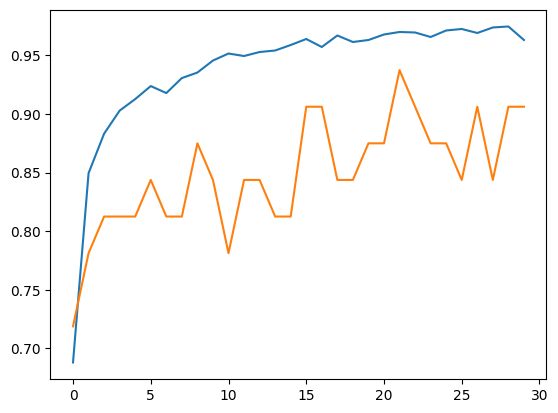

In [15]:
import matplotlib.pyplot as plt
plt.plot(acces)
plt.plot(acces_val)

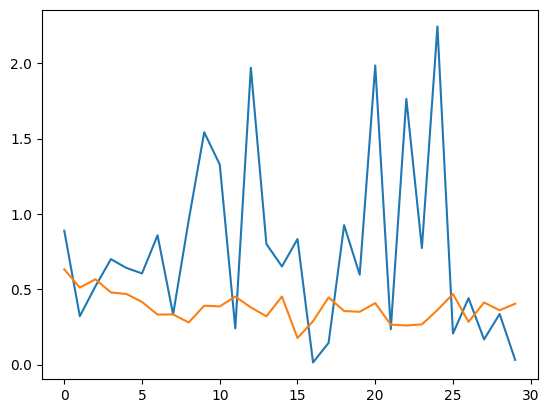

In [16]:
plt.plot(losses)
plt.plot(losses_val)

테스트셋의 정확도를 평가해봅시다.

96% 수준의 정확도를 보였습니다.

In [17]:
valid_loss = 0
valid_correct = 0

model.eval()  # 평가용 모드
with torch.no_grad():
  for x_val, y_val in test_loader:  # test set에서 정확도 평가
    x_val, y_val = x_val.to(device), y_val.to(device)
    pred_val = model(x_val)
    valid_loss += loss_fn(pred_val, y_val).item()
    print(pred_val.shape, pred_val.argmax(1))
    valid_correct += (pred_val.argmax(1) == y_val).sum().item()
    print(valid_correct)

  valid_acc = valid_correct/(len(test_data)) # 데이터 개수로 나눔
  print(valid_correct)
  losses_val.append(valid_loss)
  acces_val.append(valid_acc)
  print(f"val_loss: {valid_loss:>7f}  val_acc:{valid_acc:>5f}")

torch.Size([32, 10]) tensor([5, 4, 3, 4, 4, 9, 6, 7, 3, 4, 6, 0, 6, 5, 5, 6, 6, 0, 2, 2, 2, 7, 4, 1,
        8, 9, 3, 1, 2, 7, 0, 9], device='cuda:0')
30
torch.Size([18, 10]) tensor([0, 8, 5, 9, 1, 1, 8, 7, 1, 3, 9, 7, 8, 4, 2, 5, 8, 6], device='cuda:0')
48
48
val_loss: 0.235220  val_acc:0.960000
